In [70]:
# Import required libraries
import sys
sys.path.insert(0, "/anaconda/lib/python2.7/site-packages")
import os
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from __future__ import division
from scipy import stats
import seaborn as sns
os.chdir('/Users/wandawang/Desktop')
import re
from tpot import TPOTClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
import math
import itertools
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import ensemble

Goal: predict if a customer is satisfied or dissatisfied with their banking experience.

In [77]:
#Load training set
training = pd.read_csv('/Users/wandawang/Desktop/TPOT_Santander/train.csv', index_col=0)
X = training.iloc[:,:-1]
y = training.TARGET
#anonymized features

Notes:
Around 91% of the dataset are zeros

In [66]:
y.sum()
#3008/76020
#0.039

3008

In [46]:
#x_train = pd.read_csv('/Users/wandawang/Desktop/TPOT_Santander/train.csv')
#y_train = x_train["TARGET"]
target = np.array(y)
#x_train = x_train.drop(labels=["TARGET","ID"], axis=1)

x_test = pd.read_csv('/Users/wandawang/Desktop/TPOT_Santander/test.csv')
y_ID = x_test["ID"]
x_test.drop(labels=["ID"], axis=1, inplace=True)

In [47]:
target

array([0, 0, 0, ..., 0, 0, 0])

In [3]:
X.shape #(76020, 369) 

(76020, 369)

In [4]:
summarystats = X.describe()
summarystats.loc['unique'] = [len(X[col].unique()) for col in X.columns]
pd.options.display.max_columns = summarystats.shape[1]
summarystats

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte

Clean up the dataset:
#basic featuring excludes useless variables (all zeros and duplicates) and highly correlated variables.

0) Missingness

1) Exclude duplicates/redundant features

2) Exclude all-zero features

3) Exclude variables with collinearity above 0.8/-0.8 (1.0 being perfectly collinear)

In [42]:
x_train = X.replace(-999999,np.nan)
x_train.isnull().sum().sort_values(ascending=False)
# #var3 has 116 observations missing

# My best guess is that this variable is representing something like country
# of residence of the account. That way, 'var3 = 2' would represent Spain, and 
# 'var3 = -999999' would either be 'unknown' or something that cannot have a 
# country assigned (a society, maybe?)

In [18]:
#Data cleaning
#Treating -999999 as missing; impute with knn

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

##select the most important 220 features
selectK = SelectKBest(f_classif, k=220)
selectK.fit(X, y)
X_sel = selectK.transform(X)

features = X.columns[selectK.get_support()]


X_train = training.loc[training['var3'] != -999999, features[1:]]

y_train = training.loc[training['var3'] != -999999, 'var3']
X_test = training.loc[training['var3'] == -999999, features[1:]]
kclf = KNeighborsClassifier(n_neighbors=20)
kclf.fit(X_train, y_train)
yvar3 = kclf.predict(X_test)
yvar3



array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

In [78]:
#Replace -999999 with 2. 
X['var3'] = X['var3'].replace(-999999, 2)

In [30]:
X.var().values.shape #(369,)

(369,)

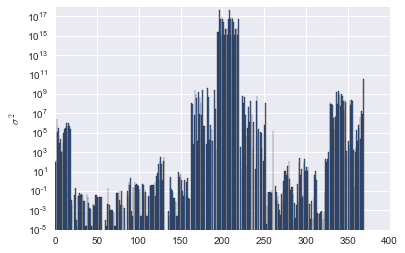

In [31]:
plt.bar(range(X.shape[1]), X.var().values) #variance for each feature
plt.gca().set_yscale('log')
plt.ylabel('$\sigma^2$')

In [79]:
def remove_zero_var(data_frame): 
    low_var_cols = []
    s2_thresh = 0.0
    n_features_originally = data_frame.shape[1]
    selector = VarianceThreshold()
    selector.fit(data_frame)
    n_features_deleted = np.delete(np.arange(data_frame.columns.size),\
                                   selector.get_support(indices=True)).size
    for col in data_frame.columns:
        if data_frame[col].var() <= s2_thresh:
            low_var_cols.append(col)
        
    print 'Columns with s^2 <= %f' % s2_thresh
    print("  - Deleted %s / %s features (~= %.1f %%)" % (
        n_features_deleted, n_features_originally,
        100.0 * (np.float(n_features_deleted) / n_features_originally)))
    #print low_var_cols

    data_frame = data_frame.drop(low_var_cols, axis=1)
    
def remove_feat_identicals(data_frame):
    print("")
    print("Deleting identical features...")
    n_features_originally = data_frame.shape[1]
    # Find the names of identical features by going through all the
    # combinations of features (each pair is compared only once).
    feat_names_delete = []
    for feat_1, feat_2 in itertools.combinations(
            iterable=data_frame.columns, r=2):
        if np.array_equal(data_frame[feat_1], data_frame[feat_2]):
            feat_names_delete.append(feat_2)
    feat_names_delete = np.unique(feat_names_delete)
    # Delete the identical features
    data_frame = data_frame.drop(labels=feat_names_delete, axis=1)
    n_features_deleted = len(feat_names_delete)
    print("  - Deleted %s / %s features (~= %.1f %%)" % (
        n_features_deleted, n_features_originally,
        100.0 * (np.float(n_features_deleted) / n_features_originally)))
    return data_frame

In [80]:
# column correlations
r = X.corr().abs()
# drop perfectly correlated columns
corr_cols = []
r_thresh = 0.8 #1.0 much more 

for i in range(r.shape[0]-1):
    for j in range(i+1, r.shape[1]):
        if r.values[i, j] >= r_thresh and r.columns[j] not in corr_cols:
            corr_cols.append(r.columns[j])
    
print 'Columns with r >= %f' % r_thresh
#print corr_cols

X = X.drop(corr_cols, axis=1)

Columns with r >= 0.800000


Columns with r == 1.000000
['ind_var29_0', 'ind_var29', 'ind_var13_medio', 'num_meses_var13_medio_ult3', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var32', 'ind_var34', 'ind_var37', 'ind_var39', 'num_var29_0', 'num_var29', 'num_var13_medio', 'num_var18', 'num_var26', 'num_var25', 'num_var32', 'num_var34', 'num_var37', 'num_var39', 'saldo_var29', 'saldo_medio_var13_medio_ult1', 'delta_num_aport_var17_1y3', 'delta_num_aport_var33_1y3', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3']


Columns with r > 1.000000
['num_var6', 'num_var29', 'num_var13_medio_0', 'num_var13_medio', 'num_var18_0', 'num_var18', 'num_var20_0', 'num_var20', 'num_meses_var13_medio_ult3', 'delta_imp_amort_var18_1y3', 'delta_imp_amort_var34_1y3', 'delta_num_aport_var13_1y3', 'num_reemb_var13_ult1', 'num_reemb_var33_ult1', 'num_trasp_var33_out_ult1', 'delta_num_venta_var44_1y3']

In [81]:
Xdata = remove_zero_var(X)

Columns with s^2 <= 0.000000
  - Deleted 34 / 166 features (~= 20.5 %)


In [82]:
Xdata = remove_feat_identicals(X)


Deleting identical features...
  - Deleted 33 / 166 features (~= 19.9 %)


In [83]:
Xdata.shape #down to (76020, 133)

(76020, 133)

In [85]:
Full_train = Xdata.iloc[:, :369]
Full_train.shape

(76020, 133)

In [87]:
#Random Forest
randomForest = ensemble.RandomForestClassifier(n_estimators=50, class_weight = 'balanced', \
                                               max_depth =10, oob_score=True)
randomForest.fit(fullzdata, y)

print str(np.sum(randomForest.feature_importances_==0)) + " useless features"

#remove unimportant features by index
feature_imprtance = zip(Full_train.columns, randomForest.feature_importances_)
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_imprtance = np.array(feature_imprtance, dtype = dtype)
feature_sort = np.sort(feature_imprtance, order='importance')[::-1]
imp = np.sort([int(i) for (i, j) in feature_sort if j!=0])
useless = [int(i) for (i, j) in feature_sort if j==0]

# filtering out the useless features in Full_train, train_target and Full_test
Full_train = Full_train.iloc[:, imp]
#Full_test = Full_test.iloc[:, imp]


27 useless features


ValueError: invalid literal for int() with base 10: 'var15'

In [88]:
#27 useless features